In [1]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

In [2]:
# from torchinfo import summary

# summary(model=yolo_nas_l, 
#         input_size=(16, 3, 640, 640),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [3]:
# url = "https://previews.123rf.com/images/freeograph/freeograph2011/freeograph201100150/158301822-group-of-friends-gathering-around-table-at-home.jpg"
# yolo_nas_l.predict(url, conf=0.25).show()

In [4]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [5]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [6]:
dataset_params_ = {
    'data_dir':'E:\\FruitPunch_files\\',
    'train_images_dir':'train-nas',
    'train_labels_dir':'train-label',
    'val_images_dir':'val-nas',
    'val_labels_dir':'val-label',
    'classes': ['Fallow Deer', 'Wild Boar', 'Domestic Cattle', 'Roe Deer', 'Domestic Sheep', 'Cervidae Family', 'Rodent', 'Red Deer', 'Animal', 'European Hare', 'European Badger', 'Golden Jackal', 'Red Fox', 'Domestic Horse', 'Domestic Goat', 'Mule Deer', 'Eurasian Red Squirrel', 'Domestic Dog', 'Mammal', 'No CV Result', 'Beech Marten', 'Eurasian Jay', 'Grey Wolf', 'Wild Cat', 'Bird', 'Martes Species', 'Reedbuck Species', 'Cervus Species', 'Canine Family', 'Persian Fallow Deer']
}

In [7]:
# ?coco_detection_yolo_format_train

In [8]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params_['data_dir'], 
        'images_dir': dataset_params_['train_images_dir'],
        'labels_dir': dataset_params_['train_labels_dir'],
        'classes': dataset_params_['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

Caching annotations:  72%|███████▏  | 1669/2320 [00:00<00:00, 8306.23it/s]

Caching annotations: 100%|██████████| 2320/2320 [00:00<00:00, 7752.83it/s]


In [9]:
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params_['data_dir'],
        'images_dir': dataset_params_['val_images_dir'],
        'labels_dir': dataset_params_['val_labels_dir'],
        'classes': dataset_params_['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

Caching annotations: 100%|██████████| 591/591 [00:00<00:00, 8776.22it/s]


In [10]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

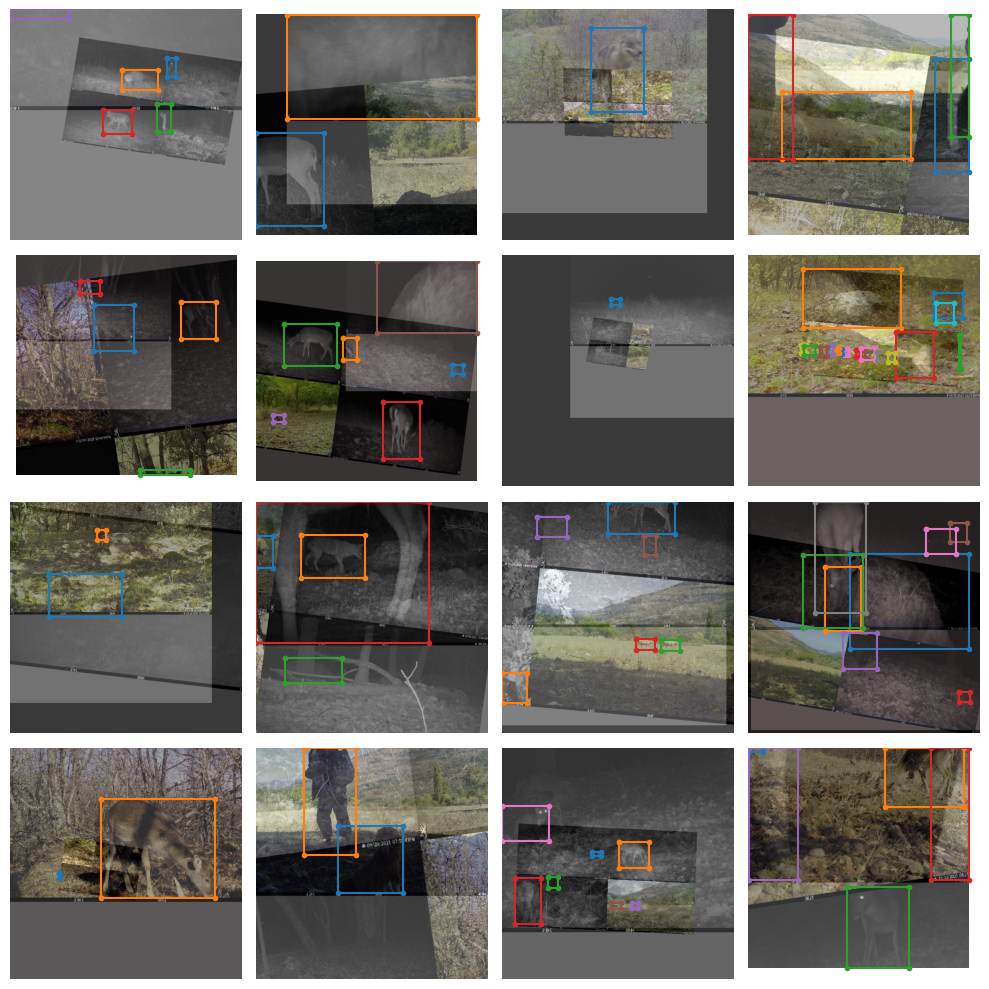

In [11]:
train_data.dataset.plot()

In [12]:
from super_gradients.training import models
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params_['classes']), 
                   pretrained_weights="coco"
                   )

In [13]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 5,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params_['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params_['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
# import sys
# sys.getdefaultencoding()
# import locale
# locale.getpreferredencoding()

#### Changes to the files 

I had to make the following two changes to the package library files 

(1) 
```
'collection' has no module Iterable
```

https://github.com/Deci-AI/super-gradients/issues/1117

Here I had to change the line 596 ```collections.Iterable``` --> ```Iterable``` 
(Note that Iterable has been imported from typing on line 14)

```
File: .venv\Lib\site-packages\super_gradients\training\utils\utils.py
```

(2)

```
'charmac' codec cannot encode characters
```

https://github.com/Deci-AI/super-gradients/issues/999

This change is as suggested in the issue 
```
File: .venv\Lib\site-packages\super_gradients\common\abstractions\mute_processes.py
```

In [14]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

Validation epoch 5: 100%|██████████| 37/37 [00:28<00:00,  1.28it/s]


In [15]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params_['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

In [17]:
trainer.test(model=best_model,
            test_loader=val_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params_['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 37/37 [00:20<00:00,  1.76it/s]


{'PPYoloELoss/loss_cls': 1.1981747,
 'PPYoloELoss/loss_iou': 0.14296158,
 'PPYoloELoss/loss_dfl': 0.88420206,
 'PPYoloELoss/loss': 1.9976798,
 'Precision@0.50': tensor(0.0391),
 'Recall@0.50': tensor(0.8685),
 'mAP@0.50': tensor(0.3774),
 'F1@0.50': tensor(0.0742)}

###Another Github Issue 

```RuntimeError: Input type (unsigned char) and bias type (float) should be the same```

https://github.com/Deci-AI/super-gradients/issues/1073

Solved it by moving the inference notebook to folder ```trainer-nas``` 
Then re-installed 
```
pip install super-gradients==3.1.1
```



In [19]:
img_url = 'https://www.mynumi.net/media/catalog/product/cache/2/image/9df78eab33525d08d6e5fb8d27136e95/s/e/serietta_usa_2_1/www.mynumi.net-USASE5AD160-31.jpg'

#"E:\\FruitPunch_files\\val\\1cbf5f8a-4635-4d8c-b0f9-7bfec4cb37ee.JPG"

best_model.predict(img_url).show()

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [22]:
import super_gradients
super_gradients.__version__

'3.1.2'